In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

! rm -r ~/.kaggle
! mkdir ~/.kaggle
! mv ./kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
! mkdir dataset
! unzip face-mask-12k-images-dataset.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1868.png

In [3]:
import cv2
import os
import numpy as np
from keras.utils import np_utils
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
import matplotlib.pyplot as plt

In [4]:
train_dir = '/content/dataset/Face Mask Dataset/Train'
valid_dir = '/content/dataset/Face Mask Dataset/Validation'
test_dir = '/content/dataset/Face Mask Dataset/Test'

In [5]:
IMG_SIZE = 224
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = 'categorical',
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = 32
)
print(train_ds.class_names)

Found 10000 files belonging to 2 classes.
['WithMask', 'WithoutMask']


In [6]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    label_mode = 'categorical',
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = 32
)

Found 800 files belonging to 2 classes.


In [7]:
model = Sequential()
pretrained = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling='avg',
    classes=2
)

87910968/87910968 [==============================] - 5s 0us/step


In [8]:
for layer in pretrained.layers:
  layer.trainable = False

In [9]:
model.add(pretrained)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 22,852,898
Trainable params: 1,050,114
Non-trainable params: 21,802,784
_________________________________________________________________


In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=1e-3),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
h = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs = 15
)

Epoch 1/15
313/313 [==============================] - 40s 90ms/step - loss: 3.6800 - accuracy: 0.8420 - val_loss: 1.4777 - val_accuracy: 0.8075
Epoch 2/15
313/313 [==============================] - 27s 85ms/step - loss: 0.4131 - accuracy: 0.9041 - val_loss: 0.2597 - val_accuracy: 0.9038
Epoch 3/15
313/313 [==============================] - 27s 84ms/step - loss: 0.2577 - accuracy: 0.9156 - val_loss: 0.2281 - val_accuracy: 0.9100
Epoch 4/15
313/313 [==============================] - 26s 83ms/step - loss: 0.1870 - accuracy: 0.9299 - val_loss: 0.1672 - val_accuracy: 0.9375
Epoch 5/15
313/313 [==============================] - 29s 91ms/step - loss: 0.1788 - accuracy: 0.9346 - val_loss: 0.1988 - val_accuracy: 0.9337
Epoch 6/15
313/313 [==============================] - 26s 83ms/step - loss: 0.1653 - accuracy: 0.9374 - val_loss: 0.1696 - val_accuracy: 0.9350
Epoch 7/15
313/313 [==============================] - 27s 84ms/step - loss: 0.1477 - accuracy: 0.9415 - val_loss: 0.1637 - val_accuracy:

1/1 [==============================] - 0s 22ms/step
WithMask
99.94476437568665 %


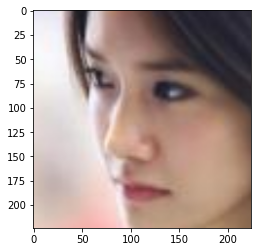

In [17]:
PATH = '/content/dataset/Face Mask Dataset/Test/WithoutMask/1835.png'
image = cv2.imread(PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224,224))
plt.imshow(image)
image = np.expand_dims(image, axis=0)
pred = model.predict(image)
i = np.argmax(pred[0])
print(train_ds.class_names[i])
print(max(pred[0])*100,'%')

In [18]:
model.save('mask-model.model', save_format='h5')